In [1]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

import unicodedata as u
import hgtk

env: TF_FORCE_GPU_ALLOW_GROWTH=true


2023-05-20 22:20:57.630991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 22:20:59.045606: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-20 22:20:59.206027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-20 22:20:59.206177: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Récupération des données

In [2]:
def recup_data(path, size=None):
    data = []
    with open(path) as file:
        for line in file.readlines():
            if line[0].isdigit():
                decomposed_text = ""
                split = line.strip().split("\t")
                for char in split[1]:
                    # si c'est un caractère coréen
                    if hgtk.checker.is_hangul(char):
                        # décomposition du caractère : 은 devient ᄋ ᅳᆫ
                        for c in u.normalize("NFD", char):
                            decomposed_text += c
                    else:
                        decomposed_text += char
                # s'il y a un + il faut segmenter
                if "+" in split[2]:
                    cat = 1
                else:
                    cat = 0
                instance = {"label":cat, "text": decomposed_text}
                data.append(instance)
    print(len(data))
    return data[:size]

In [3]:
train_data = recup_data("../data/ko_kaist-ud-train.conllu")
dev_data = recup_data("../data/ko_kaist-ud-dev.conllu")
test_data = recup_data("../data/ko_kaist-ud-test.conllu")

296446
25278
28366


## Couches de prétraitement

In [4]:
# couche de vectorisation
text_vectorizer = keras.layers.TextVectorization(
        max_tokens=15000,
        standardize="strip_punctuation",
        split="character",
        output_mode="count")

# couche de normalisation
normalizer = keras.layers.Normalization()

2023-05-20 22:21:09.686441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-20 22:21:09.687088: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-20 22:21:09.687490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-3P0J615): /proc/driver/nvidia/version does not exist
2023-05-20 22:21:09.690508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Formatage des données

In [5]:
# création du vocabulaire
text_vectorizer.adapt([x['text'] for x in train_data])
text_vectorizer.adapt([x['text'] for x in dev_data])
text_vectorizer.adapt([x['text'] for x in test_data])

# transformation des données en numpy array
X_train = np.array([text_vectorizer(d['text']) for d in train_data])
X_dev = np.array([text_vectorizer(d['text']) for d in dev_data])
X_test = np.array([text_vectorizer(d['text']) for d in test_data])

# indexation des labels
cat = list(sorted(set(d['label'] for d in train_data)))
cat_to_int = {l: i for i,l in enumerate(cat)}

# transformation des labels en numpy array
Y_train = np.array([cat_to_int[d['label']] for d in train_data])
Y_dev = np.array([cat_to_int[d['label']] for d in dev_data])
Y_test = np.array([cat_to_int[d['label']] for d in test_data])

In [6]:
# taille du vocabulaire
print(text_vectorizer.vocabulary_size())

167


## Création du modèle

In [7]:
def PerceptronModelSparseCategorical():
    inputs = keras.layers.Input(shape=(text_vectorizer.vocabulary_size(),), name="entrée")
    norm = normalizer(inputs)
    neuron = keras.layers.Dense(len(cat), activation="softmax", use_bias=True, name="couche1")(norm)
    model = keras.Model(inputs=inputs, outputs=neuron)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

model = PerceptronModelSparseCategorical()

m = PerceptronModelSparseCategorical()
m.summary()

## Entraînement du modèle

In [8]:
# entraînement
training_log = model.fit(x=X_train, y=Y_train, epochs=100, batch_size=512, validation_data=(X_dev, Y_dev), verbose=0)
print('validation accuracy', training_log.history['val_accuracy'][-1])

# on enregistre le modèle
model.save( '../models/model_classif_2.h5' ) 

validation accuracy 0.8948493003845215


## Evaluation du modèle

In [9]:
# on récupère le modèle
model = tf.keras.models.load_model('../models/model_classif_2.h5')

In [10]:
# évaluation sur les données de test
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27353453636169434
Test accuracy: 0.8873651623725891


887/887 [==============================] - 2s 2ms/step


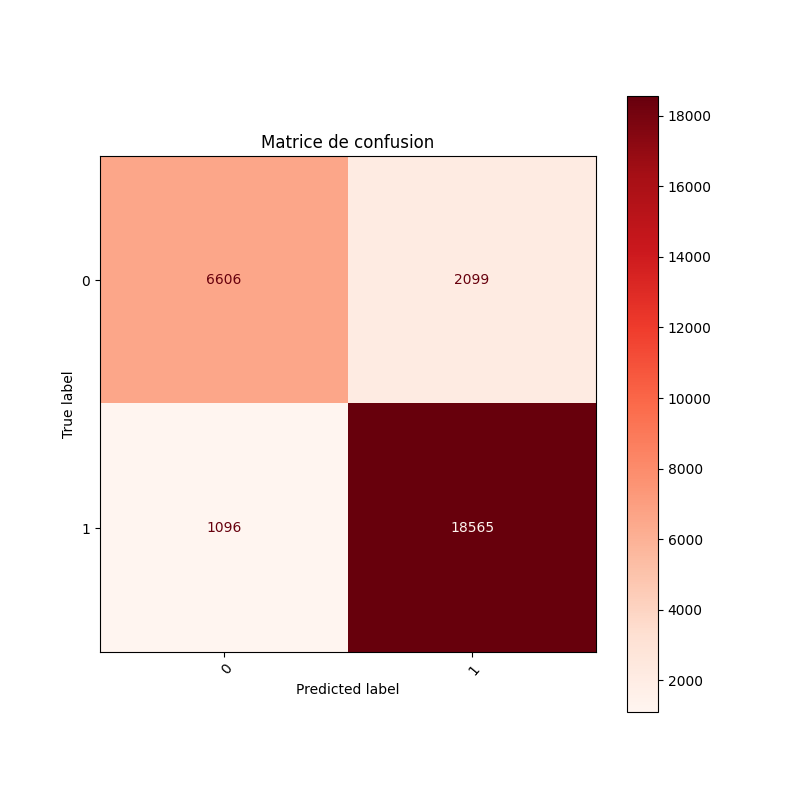

In [11]:
# prédiction et matrice de confusion
plt.close()
Y_output = model.predict(X_test)
Y_prediction = np.argmax(Y_output, axis=1)
cm = confusion_matrix(Y_test, Y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.setp(ax.get_xticklabels(), rotation=50, ha="right", rotation_mode="anchor")
ax.set_title("Matrice de confusion")
plt.show()